# Unsupervised Learning Analysis of Data Analyst Job Postings

Job seekers often have many decisions to make in preparing themselves for the market. Of these many considerations, a couple may be honing particular skills or seeking out particular types of jobs based on salary expectations. This analysis aims to use unsupervised learning tools as well as data exploration to assess some of the areas that job seekers may be interested in focusing on. 

The dataset was sourced from Kaggle [[1](#references)] and consists of data analyst job postings, with attributes including title, job description, rating, and salary estimate. The dataset first needed to be cleaned to impute some missing attribute variables as well as convert some of the data into a more usable format. Exploratory data analysis was performed to assist this cleaning, as well as to observe some interesting trends in the data. Finally, several machine learning approaches were applied to the dataset in order to extract potentially useful knowledge of the dataset, such as clusters or predictions. 

The initialization of this assessment begins with loading in the dataset and taking a look at its intial state.

In [1]:
import pandas as pd
import numpy as np
import re
from datetime import datetime
from kmodes.kmodes import KModes
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.model_selection import train_test_split
import itertools
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import ComplementNB

In [2]:
df = pd.read_csv('DataAnalyst.csv')
df.head()

,Unnamed: 0,Job Title,Salary Estimate,Job Description,Rating,Company Name,Location,Headquarters,Size,Founded,Type of ownership,Industry,Sector,Revenue,Competitors,Easy Apply
0,0,"Data Analyst, Center on Immigration and Justic...",$37K-$66K (Glassdoor est.),Are you eager to roll up your sleeves and harn...,3.2,Vera Institute of Justice\n3.2,"New York, NY","New York, NY",201 to 500 employees,1961,Nonprofit Organization,Social Assistance,Non-Profit,$100 to $500 million (USD),-1,True
1,1,Quality Data Analyst,$37K-$66K (Glassdoor est.),Overview\n\nProvides analytical and technical ...,3.8,Visiting Nurse Service of New York\n3.8,"New York, NY","New York, NY",10000+ employees,1893,Nonprofit Organization,Health Care Services & Hospitals,Health Care,$2 to $5 billion (USD),-1,-1
2,2,"Senior Data Analyst, Insights & Analytics Team...",$37K-$66K (Glassdoor est.),We’re looking for a Senior Data Analyst who ha...,3.4,Squarespace\n3.4,"New York, NY","New York, NY",1001 to 5000 employees,2003,Company - Private,Internet,Information Technology,Unknown / Non-Applicable,GoDaddy,-1
3,3,Data Analyst,$37K-$66K (Glassdoor est.),Requisition NumberRR-0001939\nRemote:Yes\nWe c...,4.1,Celerity\n4.1,"New York, NY","McLean, VA",201 to 500 employees,2002,Subsidiary or Business Segment,IT Services,Information Technology,$50 to $100 million (USD),-1,-1
4,4,Reporting Data Analyst,$37K-$66K (Glassdoor est.),ABOUT FANDUEL GROUP\n\nFanDuel Group is a worl...,3.9,FanDuel\n3.9,"New York, NY","New York, NY",501 to 1000 employees,2009,Company - Private,Sports & Recreation,"Arts, Entertainment & Recreation",$100 to $500 million (USD),DraftKings,True


## Cleaning the Dataset

In this dataset, null values are indicated by a "-1". Since this won't show up as a null value during data exploration, all values equalling -1 will be converted to NaNs. This will allow for better handling of these missing values down the line. 

After this replacement, it can be observed that there are many null values present in this dataset. This will be addressed by dropping problematic attributes, imputing the null values, or dropping the null rows.

In [3]:
# -1 values are present both as ints and strings. There are also some "unknown" values.
vals_to_replace = [-1, '-1', 'Unknown']
df.replace(vals_to_replace, None, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2253 entries, 0 to 2252
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Unnamed: 0         2253 non-null   int64 
 1   Job Title          2253 non-null   object
 2   Salary Estimate    2252 non-null   object
 3   Job Description    2253 non-null   object
 4   Rating             1981 non-null   object
 5   Company Name       2252 non-null   object
 6   Location           2253 non-null   object
 7   Headquarters       2081 non-null   object
 8   Size               2048 non-null   object
 9   Founded            1593 non-null   object
 10  Type of ownership  2074 non-null   object
 11  Industry           1900 non-null   object
 12  Sector             1900 non-null   object
 13  Revenue            2090 non-null   object
 14  Competitors        521 non-null    object
 15  Easy Apply         80 non-null     object
dtypes: int64(1), object(15)
memory usage: 281.

In [4]:
# Sample of attribute exploration. This has been performed for all features, but only one sample attribute has been kept
# as to reduce the amount of space taken up by this step of the analysis. 
df['Industry'].value_counts()

IT Services                            325
Staffing & Outsourcing                 323
Health Care Services & Hospitals       151
Computer Hardware & Software           111
Consulting                             111
                                      ... 
Truck Rental & Leasing                   1
News Outlet                              1
Catering & Food Service Contractors      1
Chemical Manufacturing                   1
Hotels, Motels, & Resorts                1
Name: Industry, Length: 88, dtype: int64

The attributes "Competitors" and "Easy Apply" will be dropped, as they contain mostly null values and are of little interest to this assessment. 

Moving forward, this analysis will make the presumption that job seekers generally care about some of these remaining attributes far more than others. The goal in this feature selection will be to best map this preference in an actionable way. The additional attributes that will be dropped are:
- "Company Name": important to the job seeker, but not useful in clustering when there are no associated company features by which to compare companies to each other. 
- "Headquarters": Most job seekers likely do not hold strong preferences here.
- "Type of ownership": Heavily imbalanced and usually of relatively little consideration.
- "Revenue": A plurality of these are unknown, and startup status will be captured by other features. 

The follow attributes will be reworked into new ones:
- "Unnamed: 0": Will be renamed as "Job ID" for the purpose of this analysis. 
- "Job Title": Will need to be reduced into more easily useable bins, as many job titles are tantamount to each other and differ primarily in a semantic sense. 
- "Salary Estimate": Will be converted into a more useable numeric format consisting of the median between the two values.
- "Job Description": Will be vectorized as to be useable by data analysis tools.
- "Founded": Will be converted to "Company Age", then binned. This should be useful as job seekers likely have a preference in working for a recent startup or not. 

The 'Industry' attribute is a special case. While it could be rather useful, it is highly obfuscated by the fact that many jobs are listed through staffing agencies that are irrelevant to the job itself. Additionally, the "Sector" attribute already captures much of the desired information of this type. However, it will be useful to keep this attribute around in order to differentiate between jobs posted via a staffing agency and jobs posted otherwise. Therefore, null values in this column will simply be imputed with the attribute mode of "IT Services".

In [5]:
# Dropping the unnecessary columns
cols_to_drop = ['Competitors', 'Easy Apply', 'Company Name', 'Headquarters', 'Type of ownership', 'Revenue']
df.drop(cols_to_drop, axis=1, inplace=True)

# Renaming the ID column
df.rename(columns={'Unnamed: 0': 'Job ID'}, inplace=True)

# Filling the null values in the 'Industry' column with the mode.
df['Industry'].fillna('IT Services', inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2253 entries, 0 to 2252
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Job ID           2253 non-null   int64 
 1   Job Title        2253 non-null   object
 2   Salary Estimate  2252 non-null   object
 3   Job Description  2253 non-null   object
 4   Rating           1981 non-null   object
 5   Location         2253 non-null   object
 6   Size             2048 non-null   object
 7   Founded          1593 non-null   object
 8   Industry         2253 non-null   object
 9   Sector           1900 non-null   object
dtypes: int64(1), object(9)
memory usage: 176.1+ KB


Since the 'Founded' attributes contains significantly more null values than the other columns, the null values will be imputed with the attribute median. The median is used in this case to account for the skew of the data, represented in the histogram below. 

Other values that are straightforward to impute, such as the numeric values of 'Rating', will be similarly handled. 

<AxesSubplot: title={'center': 'Year Founded'}, ylabel='Frequency'>

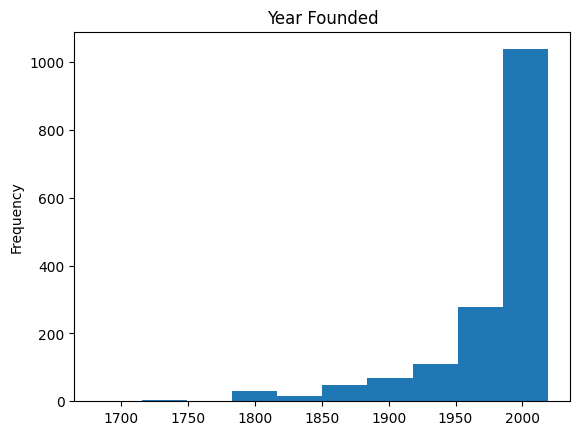

In [6]:
df['Founded'].plot(kind='hist', title='Year Founded')

<AxesSubplot: title={'center': 'Rating'}, ylabel='Frequency'>

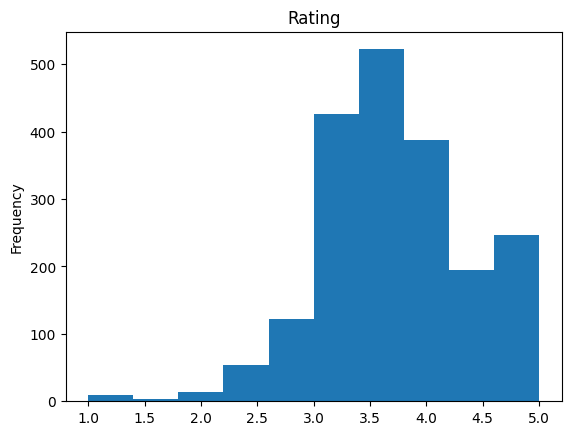

In [7]:
df['Rating'].plot(kind='hist', title='Rating')

In [8]:
df['Founded'].fillna(df['Founded'].median(), inplace=True)
df['Rating'].fillna(df['Rating'].median(), inplace=True)
df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1891 entries, 0 to 2252
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Job ID           1891 non-null   int64  
 1   Job Title        1891 non-null   object 
 2   Salary Estimate  1891 non-null   object 
 3   Job Description  1891 non-null   object 
 4   Rating           1891 non-null   float64
 5   Location         1891 non-null   object 
 6   Size             1891 non-null   object 
 7   Founded          1891 non-null   float64
 8   Industry         1891 non-null   object 
 9   Sector           1891 non-null   object 
dtypes: float64(2), int64(1), object(7)
memory usage: 162.5+ KB


Dropping the null values after imputation results in a mere 16% reduction of the dataset vs 31% that would be the case without the imputation.

Next, values in 'Salary Estimate' will be replaced with the mean of their range, as they are not usable in their string format. Splitting the range into two attributes would also be possible, but a single mean attribute will be cleaner and more useable. 

A function will loop through the database here rather than using the generally preferred Pandas 'apply' function or similar. This is because the function that needs to be applied is rather complex, and the dataframe only requires one looping. Regular expressions will be used to extract the desired information from the string. 

In [9]:
# Converts the strings of salary estimates to a more useable mean. 
def salary_averager(text):
    new_vals = re.findall('[0-9]+𝐾*', text)
    new_vals = list(map(int, new_vals))
    new_mean = np.mean(new_vals)
    return new_mean * 1000

df['Salary Estimate'] = df['Salary Estimate'].apply(salary_averager)
df.head()

,Job ID,Job Title,Salary Estimate,Job Description,Rating,Location,Size,Founded,Industry,Sector
0,0,"Data Analyst, Center on Immigration and Justic...",51500.0,Are you eager to roll up your sleeves and harn...,3.2,"New York, NY",201 to 500 employees,1961.0,Social Assistance,Non-Profit
1,1,Quality Data Analyst,51500.0,Overview\n\nProvides analytical and technical ...,3.8,"New York, NY",10000+ employees,1893.0,Health Care Services & Hospitals,Health Care
2,2,"Senior Data Analyst, Insights & Analytics Team...",51500.0,We’re looking for a Senior Data Analyst who ha...,3.4,"New York, NY",1001 to 5000 employees,2003.0,Internet,Information Technology
3,3,Data Analyst,51500.0,Requisition NumberRR-0001939\nRemote:Yes\nWe c...,4.1,"New York, NY",201 to 500 employees,2002.0,IT Services,Information Technology
4,4,Reporting Data Analyst,51500.0,ABOUT FANDUEL GROUP\n\nFanDuel Group is a worl...,3.9,"New York, NY",501 to 1000 employees,2009.0,Sports & Recreation,"Arts, Entertainment & Recreation"


As seen above, 'Salary Estimate' values have been successfully replaced. Below, a distribution is shown alongside some key metrics.

Average Salary: 72012.0
Median Salary: 68500.0


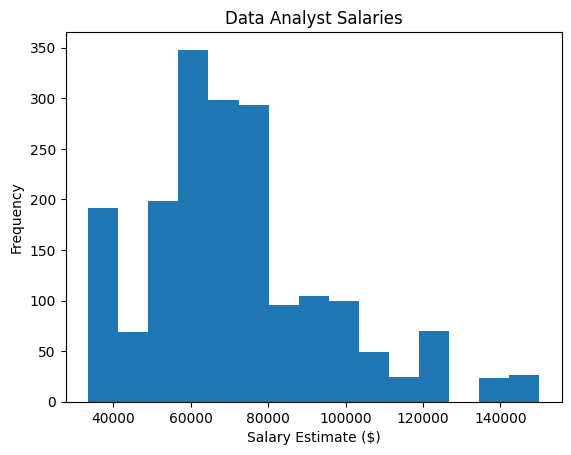

In [35]:
sal_plot = df['Salary Estimate'].plot(kind='hist', title='Data Analyst Salaries', bins=15)
sal_plot.set_xlabel('Salary Estimate ($)')
sal_mean = df['Salary Estimate'].mean()
sal_med = df['Salary Estimate'].median()
print(f'Average Salary: {np.round(sal_mean)}\nMedian Salary: {sal_med}')

Moving onto 'Job Title', the below list gives the 25 most frequent job titles. The primary keywords indicating seniority are used to remap the values of the column into a binary senior/non-senior variable. This removes particularities of naming conventions and makes jobs more comparable. The is a risk here that the non-senior title also contains senior positions, but this is mitigated by the fact that the imputed senior title should be very pure. 

In [11]:
df['Job Title'].value_counts()[:25]

Data Analyst                            333
Senior Data Analyst                      77
Junior Data Analyst                      30
Business Data Analyst                    25
Data Analyst Junior                      17
Sr. Data Analyst                         17
Data Quality Analyst                     17
Data Analyst II                          14
Lead Data Analyst                        13
Data Governance Analyst                  13
Data Reporting Analyst                   12
Data Analyst I                           10
Data Analyst III                         10
Sr Data Analyst                           9
Financial Data Analyst                    9
Marketing Data Analyst                    7
SQL Data Analyst                          7
Data Management Analyst                   7
Data Security Analyst                     6
Data Warehouse Analyst                    6
Technical Data Analyst                    6
Clinical Data Analyst                     5
Product Data Analyst            

In [12]:
sr_titles = ['senior', 'sr', 'ii', 'iii', '2', '3']

# Removes puncuation from job title, converts to lowercase, and splits into a list of individual words. 
df['Job Title'] = df['Job Title'].str.replace(r'[^\w\s]+', '', regex=True)
df['Job Title'] = df['Job Title'].str.lower()
df['Job Title'] = df['Job Title'].str.split(' ')

# Checks if a keyword denoting seniority is present and replaces title with one of two values.
df['Job Title'] = df['Job Title'].apply(lambda x: 1 if [i for i in x if i in sr_titles] else 0)

# Renaming to account for a boolean variable
df.rename(columns={'Job Title': 'Senior Position'}, inplace=True)
df['Senior Position'].value_counts()

0    1465
1     426
Name: Senior Position, dtype: int64

In [13]:
# Calculation of average salaries for positions labeled senior or otherwise. 
df.groupby('Senior Position')['Salary Estimate'].mean()

Senior Position
0    71386.006826
1    74163.145540
Name: Salary Estimate, dtype: float64

It can be seen above that a position indicated as senior makes only slightly more than otherwise. This is likely because many positions within the more general data analyst titles require levels of seniority that are not necessarily reflected in the title.

For the next step in cleaning the dataset, the attribute "Founded" will be converted to company age.

Additionally, location will be reduced to a simple state category rather than specifying the city. This will reduce the granularity, but that will likely be more useful given that the dataset is not large enough to make use of higher granularity. 

In [14]:
# Obtains the current year and replaces the year founded with the company age.
current_year = datetime.now().year
df['Founded'] = current_year - df['Founded']
df.rename(columns={'Founded': 'Company Age'}, inplace=True)

# Bins the values by quartile. Not used in this version. 
#df['Company Age'] =  pd.qcut(df['Company Age'], q=4)

# Location attribute reduced to state. 
df['Location'] = df['Location'].str.split(', ')
df['Location'] = df['Location'].apply(lambda x: x[-1])

df.head()

,Job ID,Senior Position,Salary Estimate,Job Description,Rating,Location,Size,Company Age,Industry,Sector
0,0,0,51500.0,Are you eager to roll up your sleeves and harn...,3.2,NY,201 to 500 employees,62.0,Social Assistance,Non-Profit
1,1,0,51500.0,Overview\n\nProvides analytical and technical ...,3.8,NY,10000+ employees,130.0,Health Care Services & Hospitals,Health Care
2,2,1,51500.0,We’re looking for a Senior Data Analyst who ha...,3.4,NY,1001 to 5000 employees,20.0,Internet,Information Technology
3,3,0,51500.0,Requisition NumberRR-0001939\nRemote:Yes\nWe c...,4.1,NY,201 to 500 employees,21.0,IT Services,Information Technology
4,4,0,51500.0,ABOUT FANDUEL GROUP\n\nFanDuel Group is a worl...,3.9,NY,501 to 1000 employees,14.0,Sports & Recreation,"Arts, Entertainment & Recreation"


In [15]:
# Removes the EEOC statement from the end of the job postings.
trunc = 'opportunity employer'
df['Job Description'] = df['Job Description'].apply(lambda x: x[:x.lower().find(trunc)] if trunc in x.lower() else x)

trunc2 = 'equal opportunity'
df['Job Description'] = df['Job Description'].apply(lambda x: x[:x.lower().find(trunc2)] if trunc2 in x.lower() else x)

df.reset_index(inplace=True)

Finally, the boilerplate EEOC statement was trimmed from the end of job descriptions in which it was present, as it bears little relevance on other attributes of the job and it is frequent enough to cause issues with clustering later on.

After these finishing steps and resetting the index, the dataset is now in a much cleaner and useable format that will be used in multiple applications downstream.

## K-Modes Clustering

K-means (or k-medians) clustering is a popular and useful technique for clustering numeric values. However, it does not work well with categorical variables. K-modes [[2](#references)] is a more recently adapted application that allows for clustering of categorical variables based on their frequencies rather than their numeric values. 

First, some additional tweaking of the dataset will be performed in order to prepare it for this specific application. It is typical to log-scale numeric attributes with significant variation in order to reduce impact on training models. In this case, the attributes 'Salary Estimate' and 'Company Age' were both scaled back.

This portion of the project aims to find clusters of companies that exist in the dataset. Therefore, attributes such as "Job ID" and "Senior Position" will be dropped, as they pertain to specific roles and not companies. 

In [46]:
# Dropping the attributes that pertain to the specific job posting.
df_kmodes = df.drop(['Job ID', 'Senior Position', 'Job Description'], axis=1)

# Dropping all staffing companies from this analysis.
df_kmodes.drop(df_kmodes[df_kmodes['Industry'] == 'Staffing & Outsourcing'].index, inplace=True)

# Now that 'Industry' has been used to drop staffing companies, it will be dropped due to the aforementioned reasons.
# Index will also be dropped here.
df_kmodes.drop(['Industry', 'index'], axis=1, inplace=True)

# Normalizing the more variable numeric features ('Company Age', in this case) by taking their logs.
df_kmodes['Company Age'] = np.log(df_kmodes['Company Age'].tolist())
df_kmodes['Salary Estimate'] = np.log(df_kmodes['Salary Estimate'].tolist())

df_kmodes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1571 entries, 0 to 1890
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Salary Estimate  1571 non-null   float64
 1   Rating           1571 non-null   float64
 2   Location         1571 non-null   object 
 3   Size             1571 non-null   object 
 4   Company Age      1571 non-null   float64
 5   Sector           1571 non-null   object 
dtypes: float64(3), object(3)
memory usage: 85.9+ KB


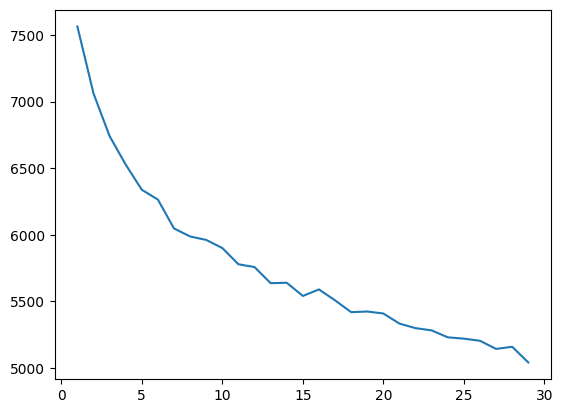

In [47]:
# Plots the cost of each model at its value k; smaller is more desirable. 
kmodes_costs = []
k_range = range(1, 30)

for k in k_range:
    kmode = KModes(n_clusters=k, init = "random", n_init = 5, verbose=0)
    kmode.fit_predict(df_kmodes)
    kmodes_costs.append(kmode.cost_)
    
plt.plot(k_range, kmodes_costs)

The elbow plot doesn't show a clear hinge that would indicate leveling off. This is likely due to the fact that the clusters have quite a large amount of natural overlap, which would be expected with this dataset. For example, even if high-paying companies tend to exist in California, many other high-paying companies exist in conceivably every state in this analysis. 

It is highly preferred to keep the number of clusters minimal if possible, for reasons of overfitting and interpretability. With this is mind, much of the sharpness of decline seems to end at around k=7, so that will be used moving forward. Analysis using a greater number of clusters can be assessed if desired.

In [48]:
kmodes = KModes(n_clusters=7, init = "random", n_init = 5, verbose=0)
kmodes.fit_predict(df_kmodes)
kmodes_results = kmodes.cluster_centroids_

In [49]:
df_kmodes_results = pd.DataFrame(kmodes_results, columns=df_kmodes.columns)

# Converting the log-scaled attributes back to their original form.
df_kmodes_results['Salary Estimate'] = np.exp(df_kmodes_results['Salary Estimate'].astype(float))
df_kmodes_results['Company Age'] = np.exp(df_kmodes_results['Company Age'].astype(float))

df_kmodes_results

,Salary Estimate,Rating,Location,Size,Company Age,Sector
0,77500.0,3.9,CA,501 to 1000 employees,21.0,Information Technology
1,59500.0,3.2,NY,51 to 200 employees,26.0,Business Services
2,99000.0,3.6,CA,1001 to 5000 employees,26.0,Finance
3,68000.0,3.7,TX,1 to 50 employees,26.0,Business Services
4,72000.0,4.0,NY,1 to 50 employees,26.0,Accounting & Legal
5,41500.0,3.3,TX,10000+ employees,28.0,Health Care
6,80500.0,5.0,CA,51 to 200 employees,15.0,Information Technology


Using this number of clusters, the data indicate some interesting trends. A couple of observations that can be made on the resulting clusters are as follows:
- These clusters occur in New York, Texas, and California, which is unsurprising given the number of jobs in those states. More states would be added if more clusters existed. 
- The type of industry seeme to vary by state and size. For example, there is a cluster of large healthcare companies in Texas, and there different IT clusters in California that bifurcate most notably on size and rating. 

Ultimately, this approach can serve to get a feel for a sample of what types of attributes are commonly associated, but it doesn't appear to be as useful as it may be for other types of problems with more distinct clusters. 

## NMF of Job Description Text

Non-negative matrix factorization [[3](#references)] can be useful in extracting data associated with specific clusters as well as predicting which labels might be associated with objects. However, before any analysis can be performed on the job description, the attribute will need to be vectorized in order to be understandable by the algorithm. 

Two more datasets are imported here:
- DataSkills: A list of dozens of skills associated with data analysis, engineering, science, and related. Sourced from [[4,5,6](#references)], in addition to my own knowledge. 
- StopWords: A list of common words to exclude from vectorization. This custom list is used as certain words like 'go' may be associated with the programming language. Sourced from [[7](#references)]. These commonly-occuring words are removed as they tend to add extra noise.

In [20]:
df_skills = pd.read_csv('DataSkills.csv')
df_stop = pd.read_csv('StopWords.csv')

In [21]:
stop_words = df_stop.word.tolist()

vect = TfidfVectorizer(sublinear_tf=True, norm='l2', min_df=0.01, max_df=0.95, ngram_range=(1, 1), stop_words=stop_words)
vectX = vect.fit_transform(df['Job Description'])
    
vectX = vectX.toarray()
df_vect = pd.DataFrame(vectX, columns=vect.get_feature_names_out())
df_vect.head()

,00,000,10,100,1000,11,12,13,15,150,...,writing,written,www,xml,years,yes,yet,york,youll,yourself
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.033574,0.00000,0.00000,0.0,0.028612,0.000000,0.0,0.000000,0.068729,0.063395
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.02993,0.00000,0.0,0.019075,0.000000,0.0,0.000000,0.000000,0.000000
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.00000,0.04949,0.0,0.020705,0.000000,0.0,0.099706,0.000000,0.000000
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.00000,0.00000,0.0,0.035045,0.079043,0.0,0.000000,0.000000,0.000000
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.00000,0.00000,0.0,0.023256,0.000000,0.0,0.066145,0.000000,0.000000


With the vectorized job descriptions created, the matrix can now be factorized. In order to give the presence of skills more weight in clustering these objects, exponentiation is used to scale skills that are present in the dataset and give them more weight. 

In [22]:
# This weighting can be adjusted (smaller = more weight).
skill_scaling = .1
skills_present = []

# Applies the weight to each skill attribute in the vectorized dataframe. 
for skill in df_skills.skill.tolist():
    if skill in df_vect.columns:
        skills_present.append(skill)
        df_vect[skill] = np.power(df_vect[skill], skill_scaling)

In [23]:
# Creating the desired matricies. 
nmf_model = NMF(n_components=3, init='random', random_state=10, max_iter=500)
W = nmf_model.fit_transform(df_vect)
H = nmf_model.components_

In [24]:
# Finds the top n words associated with each cluster.
def max_impact_words(mat, word_names, num_words=5):
    for cat in mat:
        locs = cat.argsort()[-num_words:][::-1]
        print(word_names[locs])

words = vect.get_feature_names_out()     
max_impact_words(H, word_names=words)

['tableau' 'bi' 'sql' 'microsoft' 'looker']
['database' 'sql' 'microsoft' 'oracle' 'javascript']
['python' 'sql' 'machine' 'aws' 'hadoop']


Splitting the data into three clusters results in a significant amount of overlap. This is somewhat expected, as it would be unsurprising if a majority of data analyst job postings required SQL skills, for example. Nonetheless, these clusters still convey some degree of meaningfullness. The first cluster is associated with data visualization, the second with databases, and the third with something closer to machine learning. 

Next, the matricies obtained from the NMF will be used to obtain more useful information from the original dataset based on these clusters. Each object will be assigned to a cluster, followed by metrics like salary and count being obtained for each cluster.

In [25]:
# Takes a vectorized dataframe of Job ID and word frequencies and returns a dataframe of predictions for each entry.
ordered_labels = {0:'visualization', 1:'databases', 2:'machine learning'}

df_vect_ID = df_vect.copy()

def nmf_predict(H_mat, dataframe, labels):
    df_calc = dataframe#.iloc[:, 1:]
    calcs = np.dot(H_mat, np.transpose(df_calc))
    best = calcs.argmax(axis=0)
    data = {'Category': best}
    preds = pd.DataFrame(data)
    preds = preds.replace({'Category':labels})
    return preds
    
preds = nmf_predict(H_mat = H, dataframe = df_vect_ID, labels=ordered_labels)
preds.head()

,Category
0,machine learning
1,databases
2,visualization
3,visualization
4,machine learning


In [26]:
# Creates a new dataset that appends the predicted category to each job.
df_cat = pd.concat([df, preds.Category], axis=1)

df_cat_trimmed = df_cat[['Category', 'Salary Estimate']]

cat_mean = np.round(df_cat_trimmed.groupby('Category').mean(), 2)
cat_mean.rename(columns={'Category': 'Category', 'Salary Estimate': 'Average Salary'}, inplace=True)

cat_count = df_cat_trimmed.groupby('Category').count()
cat_count.rename(columns={'Category': 'Category', 'Salary Estimate': 'Number of Listings'}, inplace=True)

display(cat_mean, cat_count)

,Average Salary
Category,
databases,69555.67
machine learning,75647.62
visualization,74336.84


,Number of Listings
Category,
databases,1006
machine learning,315
visualization,570


As seen above, the machine learning cluster is associated with the highest salaries, followed by visualization and databases. However, the frequencies of job postings of these clusters are inversely related to their salaries. 

With the clusters of skills identified and linked to average salaries, it may be of additional interest to assess the average salary associated with each individual skill. Below, a dataframe is created that links the presence of skills from the vectorized job descriptions to the salary estimate attribute of each object. This is then incorporated into a graphing function that  displays the top or bottom n skills by salary. 

In [27]:
# Creates a dataframe in which presence of skills is binary and appends salary info. 
df_vect_cat = df_vect[skills_present]
df_vect_cat = df_vect_cat.applymap(lambda x: 1 if x>0 else 0)
df_vect_cat = pd.concat([df_vect_cat, df['Salary Estimate']], axis=1)
df_vect_cat.head()

,javascript,python,go,java,matlab,scala,sql,html,nosql,perl,...,snowflake,bi,pandas,machine,aws,azure,sap,salesforce,hadoop,Salary Estimate
0,0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,51500.0
1,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,51500.0
2,0,1,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,51500.0
3,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,51500.0
4,0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,51500.0


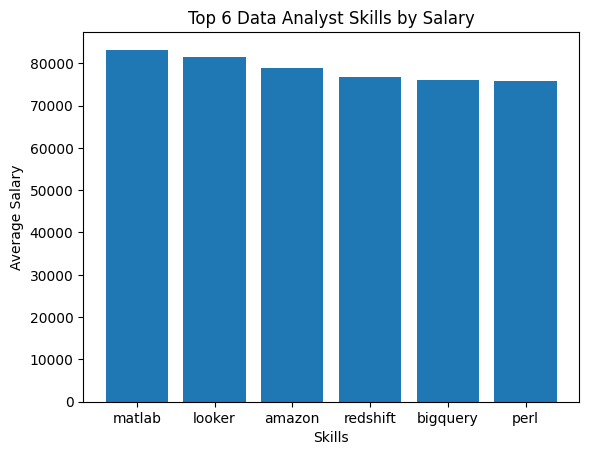

In [28]:
skill_salaries = {}

for skill in skills_present:
    avg = df_vect_cat[df_vect_cat[skill]>0]['Salary Estimate'].mean()
    skill_salaries[skill] = np.round(avg, 2)

def plot_salaries(salary_dict, n=5, high_to_low=True):    
    salary_dict = dict(sorted(salary_dict.items(), key=lambda item: item[1], reverse=high_to_low))
    skills = list(salary_dict.keys())
    salaries = list(salary_dict.values())
    
    plt.bar(range(n), salaries[:n], tick_label=skills[:n])
    
    hi_low = 'Top' if high_to_low else 'Bottom'
        
    plt.title(f'{hi_low} {n} Data Analyst Skills by Salary')
    plt.xlabel('Skills')
    plt.ylabel('Average Salary')
    plt.show()
    
plot_salaries(skill_salaries, n=6, high_to_low=True)

## Predicting Job Salary from Job Description

Now that it can be seen that there is some correlation between skills and salaries, an exploration will be made into assessing whether salary can be predicted from the job description. 

NMF, which was used previously in this project, will be used as an unsupervised approach to be compared to a supervised Bayesian benchmark. The following function takes a vectorized job description or skill dataset associated with salary expectations, and returns prediction accuracy from each model.

For the sake of simplicity (but at the cost of precision), salary estimates will be binned as high, medium, and low based on which third of the salary estimates they fall into.

In [29]:
# Takes a dataset and returns model prediction accuracies of NMF and Bayes models. 
def nmf_pipeline(dataframe):
    # Splitting up the relevant dataset into train and test, independent and target. 
    dataframe = dataframe.sample(frac=1, random_state=10)
    dataframe.reset_index(drop=True, inplace=True)
    X = dataframe.drop(['Salary Estimate'], axis=1)
    y = dataframe['Salary Estimate']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)
    
    # Obtains the necessary NMF matrix from the given dataset.
    nmf = NMF(n_components=3, init='random', random_state=10, max_iter=500)
    W_sal = nmf.fit_transform(X_train)
    H_sal = nmf.components_
    
    # Checks for the best fitting labels to use in the prediction dataset and returns accuracy. 
    perms = list(itertools.permutations(['low', 'mid', 'high']))
    
    # Finds the best fitting of labels and the associated accuracy. 
    best_perm, nmf_accuracy = {}, 0
    for perm in perms:
        sal_labels = {0:perm[0], 1:perm[1], 2:perm[2]}
        preds_sal = nmf_predict(H_mat = H_sal, dataframe = X_test, labels=sal_labels)
        accuracy = accuracy_score(y_test, preds_sal.Category)
    
        if accuracy > nmf_accuracy:
            best_perm = sal_labels
            nmf_accuracy = accuracy

    # Complement naive Bayes model to use as a testing baseline. 
    bayes_model = ComplementNB()
    bayes_model.fit(X_train, y_train)

    bayes_preds = bayes_model.predict(X_test)
    bayes_accuracy = accuracy_score(y_test, bayes_preds)
    
    nmf_accuracy = 'The accuracy of the NMF model is: ' + str(np.round(nmf_accuracy, 2))
    bayes_accuracy = 'The accuracy of the Bayes model is: ' + str(np.round(bayes_accuracy, 2))

    return nmf_accuracy, bayes_accuracy

In [30]:
# Finds the numbers at which to split the target data into thirds.
salary_cutoffs = df_vect_cat['Salary Estimate'].quantile([0.33, 0.67])

# Function that bins the dataset into 3 'quartiles'.
def bin_sals(x):
    if x<=salary_cutoffs.iloc[0]: return 'low'
    elif x<=salary_cutoffs.iloc[1]: return 'mid'
    else: return 'high'

# Creating a dataset that associates binned salaries with skills.    
df_vect_sal = df_vect_cat.copy()
df_vect_sal['Salary Estimate'] = df_vect_sal['Salary Estimate'].apply(bin_sals)

# Creating a dataset that associates binned salaries with job description texted with skills weighted more heavily. 
df_vect_full_sal = df_vect.copy() 
df_vect_full_sal = pd.concat([df_vect_full_sal, df['Salary Estimate']], axis=1)
df_vect_full_sal['Salary Estimate'] = df_vect_full_sal['Salary Estimate'].apply(bin_sals)

In [31]:
print(nmf_pipeline(df_vect_sal))
print(nmf_pipeline(df_vect_full_sal))

('The accuracy of the NMF model is: 0.38', 'The accuracy of the Bayes model is: 0.38')
('The accuracy of the NMF model is: 0.36', 'The accuracy of the Bayes model is: 0.47')


Prediciton accuracy in this application is not expected to be high due to some significant counfounding factors, such as the fact that many skills can be present in both high and low salaried jobs. 

When attributes are restricted to only the skills present in the job description, prediction accuracies between the unsupervised NMF approach and the supervised Bayes model are quite similar in that they barely surpass chance. However, when more attributes are included from the job description, the supervised approach pulls ahead to roughly 50% accuracy while the unsupervised approach remains near chance. 

<a id='references'></a>
## References

[1] "Data Analyst Jobs." Kaggle, https://www.kaggle.com/datasets/andrewmvd/data-analyst-jobs.

[2] "kmodes." Pypi, https://pypi.org/project/kmodes/.

[3] "sklearn.decomposition.NMF." Scikit learn, https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html.

[4] "The Top 20 Data Engineering Tools Used by Growing Tech Companies." Secoda, "https://www.secoda.co/blog/the-top-20-most-commonly-used-data-engineering-tools".

[5] "Top 20 Best Programming Languages To Learn in 2023." Simplilearn, "https://www.simplilearn.com/best-programming-languages-start-learning-today-article".

[6] "11 Most Popular Machine Learning Software Tools In 2023." Software Testing Help, "https://www.softwaretestinghelp.com/machine-learning-tools/".

[7] "Most common words in English." Wikipedia, "https://en.wikipedia.org/wiki/Most_common_words_in_English".